# CupIT2023–DS–MIPT

Команда: Олеся Цветкова, Андрей Евтеев, Наталья Катаева, Елена 


In [1576]:
import re
import json
import spacy
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from stop_words import get_stop_words

from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import Pipeline as imbpipeline


from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.metrics import ndcg_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import lightgbm as lgb
from lightgbm import LGBMRanker
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from sklearn.linear_model import LogisticRegression


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

import gensim
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS as stp_words

## Исследование и очистка данных

### Загрузка файла

In [2]:
df = pd.read_json('C:/Andrey/datasets/chg/ranking_train.jsonl', lines = True)

In [3]:
df.head()

,text,comments
0,How many summer Y Combinator fundees decided n...,[{'text': 'Going back to school is not identic...
1,CBS acquires last.fm for $280m,[{'text': 'It will be curious to see where thi...
2,How Costco Became the Anti-Wal-Mart,[{'text': 'I really hate it when people falsel...
3,"Fortune Favors Big Turds | Screw The Money, Th...",[{'text': 'His real point is that something ca...
4,StartupWeekend: 70 Founders Create One Company...,[{'text': 'Looks like someone hasn't read The ...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88107 entries, 0 to 88106
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      88107 non-null  object
 1   comments  88107 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [5]:
posts = df.copy()

### Очистка от спецсимволов, замена гиперссылок

Выполним обработку текста в постах: удалим большинство небуквенных и не-цифровых символов, заменим гиперссылки на http

In [6]:
#меняем гиперссылки на http
posts['text'] = posts['text'].replace(r"http\S+", "http", regex=True)
#оставляем буквы, цифры, некоторые символы (чтобы учесть темы финансов, эл адреса, интонации)
posts['text'] = posts['text'].replace(r"[^a-zA-Z0-9$@'?+!]", " ", regex=True)
# убираем символы переноса строки
posts["text"] = posts["text"].replace(r"[\n]", " ", regex=True)
# переведем в нижний регистр
posts["text"] = posts["text"].str.lower()
posts["text"] = posts["text"].replace(r"\?", " ? ", regex=True)
posts["text"] = posts["text"].replace(r"\!", " ! ", regex=True)
posts["text"] = posts["text"].replace(r"\@", " @ ", regex=True)
posts["text"] = posts["text"].replace(r"\$", " $ ", regex=True)

Добавим столбец с длиной текста в постах, проверим минмальную длину

In [1219]:
posts['length'] = posts['text'].apply(lambda x: len(x))
posts['length'].min()

0

Проверим, сколько постов длиной менее 10:

In [1220]:
len(posts.query('length <10'))

1850

Удалим записи со слишком короткими постами

In [9]:
posts = posts.query('length >=10')

In [10]:
posts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87525 entries, 0 to 88106
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      87525 non-null  object
 1   comments  87525 non-null  object
 2   length    87525 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


Выведем в новом датафрейме комментарии и ранги в отдельных столбцах:

In [11]:
d = [{f'{k}{i}': v for i,y in enumerate(x, 1) for k,v in y.items()} for x in posts['comments']]
df1 = pd.DataFrame(d, index=posts.index).sort_index(axis=1)

In [12]:
df1.head(3)

,score1,score2,score3,score4,score5,text1,text2,text3,text4,text5
0,0,1,2,3,4,Going back to school is not identical with giv...,There will invariably be those who don't see t...,For me school is a way to be connected to what...,I guess it really depends on how hungry you ar...,I know pollground decided to go back to school...
1,0,1,2,3,4,It will be curious to see where this heads in ...,Does this mean that there's now a big-name com...,Also on BBC News: http://news.bbc.co.uk/1/low...,I don't understand what they do that is worth ...,sold out too cheaply. given their leadership p...
2,0,1,2,3,4,I really hate it when people falsely claim tha...,"I love Costco. For me, the best quote of the ...","""But Mr. Sinegal warned that if Costco increas...",While Costco does treat its employees a little...,"I'd like to know more about their ""don't adver..."


In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87525 entries, 0 to 88106
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   score1  87525 non-null  int64 
 1   score2  87525 non-null  int64 
 2   score3  87525 non-null  int64 
 3   score4  87525 non-null  int64 
 4   score5  87525 non-null  int64 
 5   text1   87525 non-null  object
 6   text2   87525 non-null  object
 7   text3   87525 non-null  object
 8   text4   87525 non-null  object
 9   text5   87525 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.3+ MB


Проверим уникальные значения в столбцах с оценками

In [14]:
df1.score1.unique(), df1.score2.unique(), df1.score3.unique(), df1.score4.unique(), df1.score4.unique()

(array([0], dtype=int64),
 array([1], dtype=int64),
 array([2], dtype=int64),
 array([3], dtype=int64),
 array([3], dtype=int64))

В каждом столбце - только один тип оценки, то есть оценки идут подряд от 0 до 1 для каждой записи. Это значит, что вектор с оценками легко сгенерировать, поэтому исключим оценки:

In [15]:
df1 = df1.drop(columns = ['score1', 'score2', 'score3', 'score4', 'score5'], axis = 1)

Подготовим текст в столбцах с комментами также, как и для постов:

In [16]:
cols = ['text1', 'text2', 'text3', 'text4', 'text5']
for col in cols:
    df1[col] = df1[col].replace(r"http\S+", "http", regex=True)
    df1[col] = df1[col].replace(r"[^a-zA-Z0-9$@'?+!]", " ", regex=True)
    df1[col] = df1[col].replace(r"[\n]", " ", regex=True)
    df1[col] = df1[col].str.lower()
    df1[col] = df1[col].replace(r"\?", " ? ", regex=True)
    df1[col] = df1[col].replace(r"\!", " ! ", regex=True)
    df1[col] = df1[col].replace(r"\@", " @ ", regex=True)
    df1[col] = df1[col].replace(r"\$", " $ ", regex=True)

In [17]:
df1.head()

,text1,text2,text3,text4,text5
0,going back to school is not identical with giv...,there will invariably be those who don't see t...,for me school is a way to be connected to what...,i guess it really depends on how hungry you ar...,i know pollground decided to go back to school...
1,it will be curious to see where this heads in ...,does this mean that there's now a big name com...,also on bbc news http nice to see a london ...,i don't understand what they do that is worth ...,sold out too cheaply given their leadership p...
2,i really hate it when people falsely claim tha...,i love costco for me the best quote of the ...,but mr sinegal warned that if costco increas...,while costco does treat its employees a little...,i'd like to know more about their don't adver...
3,his real point is that something can be simpl...,so i'm thinking well i've never heard of th...,i've never seen a single blog post wander in s...,it was a rant on a personal blog it's there t...,in the eternal words of the geico caveman wh...
4,looks like someone hasn't read the mythical ma...,any chances for recreating this in a telecommu...,you know if they started with 70 and eliminat...,and what did you do this weekend ? i'd love to...,very interesting i would join an event like t...


### Исключение стоп-слов

In [18]:
posts['text'] = posts['text'].apply(lambda text: remove_stopwords(text))

In [19]:
cols = ['text1', 'text2', 'text3', 'text4', 'text5']
for col in cols:
    df1[col] = df1[col].apply(lambda text: remove_stopwords(text))

**Комментарий**
Не получается убрать стоп слова типа hasn't, хотя они есть в словаре. Придется еще раз убирать после лемматизации

In [20]:
df1.head()

,text1,text2,text3,text4,text5
0,going school identical giving founders school ...,invariably don't success set fall original pat...,school way connected going real world entered ...,guess depends hungry believe product i'm 24 sc...,know pollground decided school getting y combi...
1,curious heads long run cbs tear fit image try ...,mean there's big company fight repeal recent s...,bbc news http nice london based hit headlines,don't understand worth $ 70m year,sold cheaply given leadership position ask $ 500m
2,hate people falsely claim fiduciary responsibi...,love costco best quote article traditional ret...,mr sinegal warned costco increased markups 16 ...,costco treat employees little bit better peopl...,i'd like know don't advertise strategy upscale...
3,real point simple powerful order sound edgy su...,i'm thinking i've heard bug tracker called 'mo...,i've seen single blog post wander directions f...,rant personal blog it's vent frustration vapid...,eternal words geico caveman ?
4,looks like hasn't read mythical man month,chances recreating telecommuting way ? loved a...,know started 70 eliminated reality style total...,weekend ? i'd love hear like happens nyc nyc s...,interesting join event like happens sv equity fun


In [21]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87525 entries, 0 to 88106
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text1   87525 non-null  object
 1   text2   87525 non-null  object
 2   text3   87525 non-null  object
 3   text4   87525 non-null  object
 4   text5   87525 non-null  object
dtypes: object(5)
memory usage: 4.0+ MB


### Лемматизация

In [22]:
# загружаем модуль для лемматизации
nlp = spacy.load("en_core_web_sm")

C:\Users\antwo\AppData\Roaming\Python\Python39\site-packages\spacy\util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.3.0) was trained with spaCy v3.3 and may not be 100% compatible with the current version (3.4.3). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [23]:
# применяем лемматизацию к словам в предложениях из столбца датафрейма, исключая пробелы
tqdm.pandas()
posts['lemm'] = posts['text'].progress_apply(lambda text: " ".join(token.lemma_ for token in nlp(text)
                                                                if not token.is_space))

100%|██████████| 87525/87525 [11:02<00:00, 132.13it/s]


In [24]:
posts['lemm'] = posts['lemm'].apply(lambda text: remove_stopwords(text))

In [25]:
# исключаем апострофы (могли остаться, если были в словах, которые не подходят под схемы для лемматизации)
posts["lemm"] = posts["lemm"].replace(r"[']", " ", regex=True)

In [26]:
# удаляем столбец с исходным текстом
posts = posts.drop(columns=['text'], axis=1)

In [27]:
# удаляем столбец с комментариями
posts = posts.drop(columns=['comments'], axis=1)

In [28]:
posts = posts.rename(columns = {'lemm': 'text'})

In [29]:
posts.head()

,length,text
0,133,summer y combinator fundee decide continue sta...
1,32,cbs acquires fm $ 280 m
2,35,costco anti wal mart
3,58,fortune favor big turd screw money art
4,59,startupweekend 70 founder create company weekend


In [30]:
# сохраняем полученный файл
filepath = Path('C:/Andrey/datasets/chg/posts_text_lemmatized.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
posts.to_csv(filepath, index=False)

Загрузка сохраненного файла после лемматизации

In [93]:
df_posts = pd.read_csv('C:/Andrey/datasets/chg/posts_text_lemmatized.csv')

In [94]:
df_posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87525 entries, 0 to 87524
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   length  87525 non-null  int64 
 1   text    87494 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [95]:
df_posts = df_posts.fillna(' ')

#### Лемматизация комментов

In [34]:
# применяем лемматизацию к словам в предложениях из столбца датафрейма, исключая пробелы
tqdm.pandas()
df1['lemm1'] = df1['text1'].progress_apply(lambda text: " ".join(token.lemma_ for token in nlp(text)
                                                                if not token.is_space))

100%|██████████| 87525/87525 [23:57<00:00, 60.90it/s] 


In [35]:
# применяем лемматизацию к словам в предложениях из столбца датафрейма, исключая пробелы
tqdm.pandas()
df1['lemm2'] = df1['text2'].progress_apply(lambda text: " ".join(token.lemma_ for token in nlp(text)
                                                                if not token.is_space))

100%|██████████| 87525/87525 [18:55<00:00, 77.10it/s] 


In [36]:
# применяем лемматизацию к словам в предложениях из столбца датафрейма, исключая пробелы
tqdm.pandas()
df1['lemm3'] = df1['text3'].progress_apply(lambda text: " ".join(token.lemma_ for token in nlp(text)
                                                                if not token.is_space))

100%|██████████| 87525/87525 [19:15<00:00, 75.73it/s] 


In [37]:
# применяем лемматизацию к словам в предложениях из столбца датафрейма, исключая пробелы
tqdm.pandas()
df1['lemm4'] = df1['text4'].progress_apply(lambda text: " ".join(token.lemma_ for token in nlp(text)
                                                                if not token.is_space))

100%|██████████| 87525/87525 [21:19<00:00, 68.41it/s]  


In [38]:
# применяем лемматизацию к словам в предложениях из столбца датафрейма, исключая пробелы
tqdm.pandas()
df1['lemm5'] = df1['text5'].progress_apply(lambda text: " ".join(token.lemma_ for token in nlp(text)
                                                                if not token.is_space))

100%|██████████| 87525/87525 [17:30<00:00, 83.35it/s] 


In [40]:
lmt = [['lemm1', 'lemm2', 'lemm3','lemm4','lemm5']]

for col in lmt:
    df1[col] = df1[col].replace(r"[']", "", regex=True)

In [41]:
# удаляем столбец с исходным текстом
df2 = df1.drop(columns=['text1', 'text2','text3','text4','text5'], axis=1)

In [42]:
# сохраняем полученный файл
filepath = Path('C:/Andrey/datasets/chg/comm_text_lemmatized.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df2.to_csv(filepath, index=False)

In [96]:
df_comm = pd.read_csv('C:/Andrey/datasets/chg/comm_text_lemmatized.csv')

In [97]:
df_comm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87525 entries, 0 to 87524
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   lemm1   87522 non-null  object
 1   lemm2   87521 non-null  object
 2   lemm3   87519 non-null  object
 3   lemm4   87505 non-null  object
 4   lemm5   87496 non-null  object
dtypes: object(5)
memory usage: 3.3+ MB


In [98]:
df_comm = df_comm.fillna(' ')

#### Очистка от коротких постов и комментариев

После лемматизации и удаления стоп-слов появились короткие тексты. Объединим посты и комментарии в один датафрейм:

In [1474]:
clean = df_posts.join(df_comm)

In [1475]:
clean.head()

,length,text,lemm1,lemm2,lemm3,lemm4,lemm5
0,133,summer y combinator fundee decide continue sta...,go school identical giving founder school work...,invariably do not success set fall original pa...,school way connect go real world enter school ...,guess depend hungry believe product I be 24 sc...,know pollground decide school get y combinator...
1,32,cbs acquires fm $ 280 m,curious head long run cbs tear fit image try e...,mean there be big company fight repeal recent ...,bbc news http nice london base hit headline,do not understand worth $ 70 m year,sell cheaply give leadership position ask $ 500 m
2,35,costco anti wal mart,hate people falsely claim fiduciary responsibi...,love costco good quote article traditional ret...,mr sinegal warn costco increase markup 16 18 p...,costco treat employee little bit well people n...,I would like know do not advertise strategy up...
3,58,fortune favor big turd screw money art,real point simple powerful order sound edgy su...,I be think I ve hear bug tracker call mongrel...,I ve see single blog post wander direction fog...,rant personal blog it be vent frustration vapi...,eternal word geico caveman ?
4,59,startupweekend 70 founder create company weekend,look like have not read mythical man month,chance recreate telecommute way ? love attend ...,know start 70 eliminate reality style totally ...,weekend ? I would love hear like happen nyc ny...,interesting join event like happen sv equity fun


In [1476]:
clean= clean.fillna(' ')

Определим длину для каждого поста и комментария:

In [1477]:
clean['length'] = clean['text'].apply(lambda x: len(x))

In [1478]:
clean['len1'] = clean['lemm1'].apply(lambda x: len(x))
clean['len2'] = clean['lemm2'].apply(lambda x: len(x))
clean['len3'] = clean['lemm3'].apply(lambda x: len(x))
clean['len4'] = clean['lemm4'].apply(lambda x: len(x))
clean['len5'] = clean['lemm5'].apply(lambda x: len(x))

Посты меньше 5 знаков, комменты 1-5 меньше 10 знаков:

In [1479]:
len(clean.query('length <5')), len(clean.query('len1 <10')), len(clean.query('len2 <10')), len(clean.query('len3 <10')), len(clean.query('len4 <10')), len(clean.query('len5 <10'))

(290, 205, 332, 512, 838, 1375)

In [1480]:
len(clean.query('len4 <4')), len(clean.query('len5 <4'))

(49, 111)

Визуализируем распределение постов и комментов по длине:

<AxesSubplot:xlabel='variable', ylabel='value'>

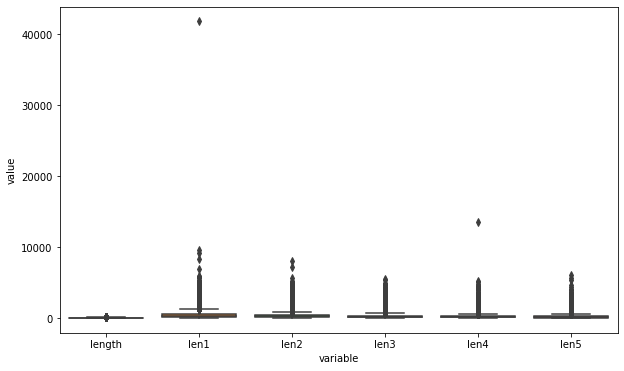

In [1481]:
plt.figure(figsize=(10, 6))

len_data = clean[['length', 'len1', 'len2', 'len3', 'len4','len5']]

sns.boxplot(x="variable", y="value", data=pd.melt(len_data))

(0.0, 2000.0)

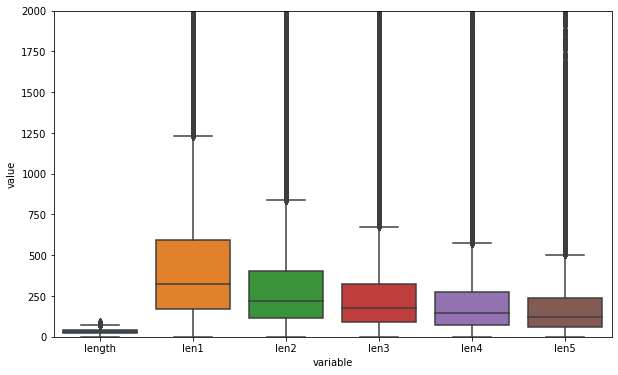

In [1482]:
ax = plt.figure(figsize=(10,6))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(len_data))
ax.set_ylim(0,2000)

Исключим посты меньше 5 знаков, комменты 1,2 и 3 меньше 10 знаков, комменты 4 и 5 меньше 4 знаков:

In [1483]:
clean = clean.query('length >=5')
clean = clean.query('len1 >=10')
clean = clean.query('len2 >=10')
clean = clean.query('len3 >=10')
clean = clean.query('len4 >=4')
clean = clean.query('len5 >=4')

Исключим комментарии длиной больше 2000 для первого коммента и больше 1000 для остальных

In [1484]:
clean = clean.query('len1 <=1200')
clean = clean.query('len2 <=1000')
clean = clean.query('len3 <=750')
clean = clean.query('len4 <=750')
clean = clean.query('len5 <=750')

In [1485]:
clean = clean.drop(columns = ['length', 'len1', 'len2', 'len3', 'len4', 'len5'], axis = 1)

In [1240]:
# сохраняем полученный файл
filepath = Path('C:/Andrey/datasets/chg/clean_text.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
clean.to_csv(filepath, index=False)

In [1241]:
clean = pd.read_csv('C:/Andrey/datasets/chg/clean_text.csv')

In [1486]:
clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72010 entries, 0 to 87524
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    72010 non-null  object
 1   lemm1   72010 non-null  object
 2   lemm2   72010 non-null  object
 3   lemm3   72010 non-null  object
 4   lemm4   72010 non-null  object
 5   lemm5   72010 non-null  object
dtypes: object(6)
memory usage: 3.8+ MB


### Деление на тестовую и обучающую

In [1487]:
# выделим выборки для обучения на векторизации
train, test = (train_test_split(clean, train_size=0.8,
                                                  random_state=38))

In [1488]:
train.shape

(57608, 6)

In [1489]:
test.shape

(14402, 6)

In [1246]:
train.head(2)

,text,lemm1,lemm2,lemm3,lemm4,lemm5
72401,xwayland xorg,interesting blog post http explain question po...,know explain help use x dependent window manag...,user modern linux distribution expect near fut...,hope driver catch egl x2f wayland support espe...,isn x27 t exact text x27 s quote nvidia reply ...
61765,light table 0 5 0,love little spinning glider lower leave x27 t ...,great work x27 t wait plugin arrive ! great te...,package lighttable app anymore ? unzip x27 s f...,release lighttable x27 ve experiment promise !...,quot watch quot feature video actually quot wo...


In [1247]:
test.head(2)

,text,lemm1,lemm2,lemm3,lemm4,lemm5
50772,ask hn ?,quit ? use spare time building skill sure lear...,like compsci ? score low take 4 yr have not ma...,thing feel like crap depressed need eat well e...,score percentage do not matter code ? great ! ...,need realize life go kick ass leave bleed floo...
63359,work home today office loud,topic come hn discuss impact people x27 s heal...,open office line item cost cut measure destroy...,exactly ibm x27 s recommendation 1970s era ana...,open office plan suuuuuuuuuuuck soul crush pro...,maybe flat refuse work office natural light x2...


## Подготовка признаков

### Признаки с векторизацией TF IDF 

#### Подготовка для TF IDF: объединенный текст в новом столбце
Для обучения TF IDF используем только обучающую выборку. Чтобы получить корпус текста для обучения, объединим столбцы с текстом комментами

In [1490]:
train['all'] = (train['text'] + ' ' + train['lemm1'] + " " + train['lemm2'] + " " +
                     train['lemm3'] + ' ' + train['lemm4'] + " " + train['lemm5'])

In [1491]:
train.head()

,text,lemm1,lemm2,lemm3,lemm4,lemm5,all
58322,launch bootstrappe startup think ?,nice manage church s website do not time const...,curiosity application setup ? whmcs manage dom...,congrat ! approach church process ? pay custom...,def big interesting market what be plan reach ...,look great good luck I ve bookmarke blog,launch bootstrappe startup think ? nice manage...
5406,ask hn proposal manage addictiveness site,it will pass month time click override procras...,it be fault clear guy miss point post I be ask...,noprocast setting wonderful thing I would chan...,like care people internet think pretty shamele...,problem story time sensitive example lot good ...,ask hn proposal manage addictiveness site it w...
34229,google+ update real policy,do not actually change policy enforcement you ...,leave g+ week ago delete g+ account profile I ...,listen learn iterate user good experience poss...,lot good comment page policy page list example...,know opinion popular support enforcement real ...,google+ update real policy do not actually cha...
57460,google smartphone real deal,62 window phone enter dangerous time competito...,killer feature google actually helpful basebal...,google lot promise I ve bite release it be act...,use google I ve get surprised predict go base ...,do not agree thurrott think spot google killer...,google smartphone real deal 62 window phone en...
12246,22 musical piece write 140 character code,musical piece fascinate algorithmic point view...,I ve spend day far play sclang 1 it be nice la...,remind module music demoscene http,fun language library ? do not understand infor...,argh ear ! loud ! I will stick analogue synth,22 musical piece write 140 character code musi...


In [1492]:
# Получим словарь стоп-слов
st_words = get_stop_words('english')

In [1493]:
# корпус для обучения
corpus = train['all'].values

In [1494]:
# инициализируем TfidfVectorizer
count_tf_idf = TfidfVectorizer(stop_words=st_words,  
                               min_df= 0.0005, token_pattern=r"\S+")

In [1495]:
# применяем расчет TF IDF к обучающей выборке
tf_idf = count_tf_idf.fit_transform(corpus)
tf_idf.shape

(57608, 12801)

#### Получение "выпрямленных таблиц" для трейна и теста

Для вычсиления TF IDF на индивидуальных комментариях с целью обучения модели нужно "выпрямить" таблицу, развернув все комментарии в один столбец

#####  Разворачивание для обучающей выборки:

Составим функцию, которая разворачивает комментарии в один столбец

In [1496]:
def get_df(df):
    """
    Функция разворачивает столбцы с комментариями в один стобец
    """
    
    
    data = {'comment': []}
    cols = ['lemm1', 'lemm2', 'lemm3', 'lemm4', 'lemm5']

    for i in range(len(df)):    
        for col in cols:
            data['comment'].append(df.iloc[i][col])
    new_df = pd.DataFrame.from_dict(data)
    return new_df

In [1497]:
train_comm = get_df(train)

In [1498]:
train_comm.shape

(288040, 1)

Добавим столбец с оценками:

In [1499]:
# таргеты для обучающей выборки
y_train = np.tile(np.arange(5), len(train))
train_comm['score'] = y_train 

Добавим столбец с бинарными оценками (0 и 1 соответствуют 1, а 2,3 и 4 - 0)

In [1500]:
train_comm['binary_score'] = np.where(train_comm['score'].isin([0,1]), 1, 0)

In [1501]:
train_comm.head(3)

,comment,score,binary_score
0,nice manage church s website do not time const...,0,1
1,curiosity application setup ? whmcs manage dom...,1,1
2,congrat ! approach church process ? pay custom...,2,0


Выделим выборку, содержащую лучшие (0) и худшие (1) посты

In [1502]:
train_binary = train_comm[train_comm['score'].isin([0, 4])]

In [1503]:
train_binary.shape

(115216, 3)

Получим вектор с целевыми бинарными значениями для обучающей выборки 

In [1504]:
y_binary = train_binary['binary_score']

In [1505]:
y_binary.shape

(115216,)

##### Разворачивание для тестовой выборки:

In [1506]:
test_comm = get_df(test)

In [1507]:
test_comm.shape

(72010, 1)

In [1508]:
# таргеты для тестовой выборки
y_test = np.tile(np.arange(5), len(test))
test_comm['score'] = y_test

In [1509]:
test_comm.head(5)

,comment,score
0,eth z rich http bertrand meyer eiffel ueli mau...,0
1,imperial college cambridge university excellen...,1
2,highly depend want study science pretty broad ...,2
3,probably look middle postgraduate master msc o...,3
4,base reputation it be undoubtedly cambridge im...,4


#### Вычисление значений TF IDF

In [1510]:
train_corpus = train_comm['comment'].values

In [1511]:
test_corpus = test_comm['comment'].values

In [1512]:
X_trcorpus = X_tr1['comment'].values

In [1513]:
train_bin_corpus = train_binary['comment'].values

In [1514]:
# применяем расчет TF IDF к комментариям для обучающей выборки
tf_train = count_tf_idf.transform(train_corpus)
tf_train.shape

(288040, 12801)

In [1515]:
# применяем расчет TF IDF к комментариям для тестовой выборки
tf_test = count_tf_idf.transform(test_corpus)
tf_test.shape

(72010, 12801)

In [1516]:
# применяем расчет TF IDF к обучающей выборке с бинарными значениями
tf_binary = count_tf_idf.transform(train_bin_corpus)
tf_binary.shape

(115216, 12801)

### Создание признаков по длинам и по векторам CountVectorizer 

Составим функцию, которая извлекает из датафрейма признаки на основе текстов и на основе векторизованных текстов.
Признаки: относительные длины комментов и словарей комментов, количество спец символов, гиперссылок, косинальное сходство относительно поста и эвклидово расстояние с вектором поста

In [1275]:
def get_features(df):
    """
    Функция для получения признаков из характеристик текста и из векторизованных представлений
    Принимает датафреймы, в которых имеются столбцы 'lemm1', 'lemm2', 'lemm3', 'lemm4', 'lemm5' для комментов
    и столбец 'text' для постов
    """
    data = ({'relative_length': [], 'len_to_vocabulary': [], 'word_count': [], 'word_ratio':[], 'ratio_post': [],
          'word_ratio_post': [], 'numbers': [], 'hyperlinks': [], 'dot': [], 'question': [], 'exclamation': [], 
          'dollars': [], 'cosine': [], 'euclidean': []}
          )
    vectorizer = CountVectorizer(stop_words = st_words)
    cols = ['lemm1', 'lemm2', 'lemm3', 'lemm4', 'lemm5']
    
    for i in range(len(df)):

    # составим список из текста поста и комментов
        txt = ([df.iloc[i]['text'], df.iloc[i]['lemm1'], df.iloc[i]['lemm2'],
            df.iloc[i]['lemm3'], df.iloc[i]['lemm4'], df.iloc[i]['lemm5']])
        X = vectorizer.fit_transform(txt) #векторизация полученного корпуса
        vect = X.toarray()
        sum_length = np.sum(vect[1]) + np.sum(vect[2]) + np.sum(vect[3]) + np.sum(vect[4]) + np.sum(vect[5])

        num = range(1,6)
        for k, col in zip(num, cols):
            comment = df.iloc[i][col]
            # длина коммента относительно суммарной длины комментов
            data['relative_length'].append(np.sum(vect[k])/sum_length) 
            # длина коммента относительно количества уникальных слов в комментариях
            data['len_to_vocabulary'].append(np.sum(vect[k])/vect[k].size)
            # количество уникальных слов в комментарии
            data['word_count'].append(np.count_nonzero(vect[k]))
            # отношение количества уникальных слов к словарю записи
            data['word_ratio'].append(np.count_nonzero(vect[k])/vect[k].size)
            # отношение длины коммента к длине поста
            data['ratio_post'].append(np.sum(vect[k])/(np.sum(vect[0])+1))
            #  отношение количества уникальных слов в комменте к количеству уникальных слов в посте
            data['word_ratio_post'].append(np.count_nonzero(vect[k])/(np.count_nonzero(vect[0])+1))
            data['numbers'].append(len(re.findall('[0-9]+', comment))) 
            data['hyperlinks'].append(len(re.findall("(http?)", comment)))
            data['dot'].append(len(re.findall("(@)", comment)))
            data['question'].append(len(re.findall("(\?)", comment)))
            data['exclamation'].append(len(re.findall("(!)", comment)))                                              
            data['dollars'].append(len(re.findall("(\$)", comment)))
            data['cosine'].append(cosine_similarity(vect[0].reshape(-1,1).T, vect[k].reshape(-1,1).T)[0][0])
            data['euclidean'].append(euclidean_distances(vect[0].reshape(-1,1).T, vect[k].reshape(-1,1).T)[0][0])   
    return data

Получим признаки из обучающей выборки

In [1517]:
train_features = get_features(train)

C:\Users\antwo\.conda\envs\ds_copy\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'can', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [1518]:
# датафрейм для признаков из обучающей выборки
X_train_data = pd.DataFrame.from_dict(train_features)

In [1519]:
X_train_data.shape

(288040, 14)

In [1520]:
X_train_data.head(3)

,relative_length,len_to_vocabulary,word_count,word_ratio,ratio_post,word_ratio_post,numbers,hyperlinks,dot,question,exclamation,dollars,cosine,euclidean
0,0.827586,1.166667,118,0.819444,33.6,23.6,4,0,0,1,1,3,0.082076,18.220867
1,0.064039,0.090278,12,0.083333,2.6,2.4,0,0,0,2,0,0,0.000000,4.358899
2,0.029557,0.041667,6,0.041667,1.2,1.2,0,0,0,2,1,0,0.000000,3.162278


In [1521]:
# таргеты для обучающей выборки
y_train = np.tile(np.arange(5), len(train))
y_train.shape

(288040,)

In [1522]:
# объединенный датафрейм с признаками и таргетом для обучающей выборки
train_data = X_train_data.copy()
train_data['score'] = y_train

Получим признаки для тестовой выборки

In [1523]:
test_features = get_features(test)

C:\Users\antwo\.conda\envs\ds_copy\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'can', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [1524]:
# датафрейм для признаков из тестовой выборки
X_test_data = pd.DataFrame.from_dict(test_features)
X_test_data.shape

(72010, 14)

In [1525]:
# таргет для тестовой выборки
y_test = np.tile(np.arange(5), len(test))
y_test.shape

(72010,)

In [1526]:
# датафрейм с признаками и таргетом для тестовой выборки
test_data = X_test_data.copy()
test_data['score'] = y_test

In [1527]:
test_data[50:55]

,relative_length,len_to_vocabulary,word_count,word_ratio,ratio_post,word_ratio_post,numbers,hyperlinks,dot,question,exclamation,dollars,cosine,euclidean,score
50,0.195489,0.240741,22,0.203704,5.2,4.4,0,0,0,0,0,0,0.000000,6.164414,0
51,0.473684,0.583333,51,0.472222,12.6,10.2,3,0,0,0,0,3,0.157243,9.433981,1
52,0.090226,0.111111,11,0.101852,2.4,2.2,0,0,0,0,0,0,0.133631,4.000000,2
53,0.067669,0.083333,9,0.083333,1.8,1.8,0,0,0,0,0,0,0.000000,3.605551,3
54,0.172932,0.212963,22,0.203704,4.6,4.4,1,0,0,0,0,0,0.100000,5.196152,4


In [1528]:
# сохраняем полученный файл
filepath = Path('C:/Andrey/datasets/chg/train_data.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
train_data.to_csv(filepath, index=False)

In [152]:
# сохраняем полученный файл
filepath = Path('C:/Andrey/datasets/chg/test_data.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
test_data.to_csv(filepath, index=False)

In [153]:
# сохраняем полученный файл
filepath = Path('C:/Andrey/datasets/chg/X_train_data.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
X_train_data.to_csv(filepath, index=False)

In [154]:
# сохраняем полученный файл
filepath = Path('C:/Andrey/datasets/chg/X_test_data.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
X_test_data.to_csv(filepath, index=False)

Метки для записей в выборке:

In [1529]:
train_ids = np.repeat(np.arange(int(len(X_train_data)/5)), 5)

In [1530]:
train_ids.shape

(288040,)

In [1531]:
val_ids = np.repeat(np.arange(int(len(X_test_data)/5)), 5)

In [1532]:
val_ids.shape

(72010,)

### Векторизация CountVectorizer с n gram 

Составим функцию для получения векторов для каждой группы (пост + 5 комментариев), учитывая отдельные слова и комбинации слов по 2, то есть с использованием ngram_range=(1,2):

In [1290]:
def get_vectors(df):
    vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(1, 2))
    data = {'comm_vector': []}
    cols = ['lemm1', 'lemm2', 'lemm3', 'lemm4', 'lemm5']

    for i in range(len(df)):    
        txt = ([df.iloc[i]['text'], df.iloc[i]['lemm1'], df.iloc[i]['lemm2'],
            df.iloc[i]['lemm3'], df.iloc[i]['lemm4'], df.iloc[i]['lemm5']])
        X2 = vectorizer2.fit_transform(txt)
        vectors = X2.toarray()
        
        for k in range(1,6):
            data['comm_vector'].append(vectors[k])
    return data

Получим векторы для комментариев в  обучающей и тестовой выборках:

In [1291]:
vtrain = get_vectors(train)

In [1292]:
vtest = get_vectors(test)

Получим векторы для комментариев в обучающей выборке:

In [1293]:
len(vtest['comm_vector'])

79965

In [1294]:
len(vtrain['comm_vector'])

319840

.... \
...\
???\
PROFIT!

(не придумали, что дальше)

## Обучение моделей
### Обучение по признакам из характеристик слов и векторов

#### Регрессия: LGBMRegressor, признаки из характеристик слов и векторов
Выполним обучение регрессии, используя значения ранга от 0 до 4 в качестве целевого признака. Затем будем предсказывать значения, сортировать и назначать ранги по возрастанию


In [1533]:
# создадим модель LGBMRegressor
lgbm = LGBMRegressor(random_state=38)

# создадим список гиперпараметров
lgbm_parameters = {
    'num_leaves': [15, 20],
    'n_estimators': [100, 160],
    'learning_rate': [0.05, 0.1],
    'max_depth': [9, 10]
}

# передадим модель и гиперпараметры для обучения с кросс-валидацией и для подбора гиперпаматеров
lgbm_cv = GridSearchCV(lgbm,
                    param_grid=lgbm_parameters,
                    scoring='neg_mean_absolute_error',
                    cv=5)

Векторы с целевым признаком составлены в соответствии с размером выборок и учитывают упорядоченность меток для каждого поста от 0 к 4:

In [1534]:
y_train = np.array((0,1,2,3,4)*int(len(X_train_data)/5))
y_test = np.array((0,1,2,3,4)*int(len(X_test_data)/5))

In [1535]:
y_train.shape, y_test.shape 

((288040,), (72010,))

Выполним обучение модели

In [1536]:
%%time
# выполним обучение модели с подбором гиперпараметров
lgbm_cv.fit(X_train_data, y_train)

CPU times: total: 5min 33s
Wall time: 2min 51s


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=38),
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [9, 10],
                         'n_estimators': [100, 160], 'num_leaves': [15, 20]},
             scoring='neg_mean_absolute_error')

Выведем значение метрики MAE при обучении:

In [1537]:
lgbm_cv.best_score_

-1.0541684720540097

In [1572]:
# сохраним модель LGBMRegressor
lgbm_best = lgbm_cv.best_estimator_

In [1589]:
lgbm_best_param = lgbm_cv.best_params_

In [1590]:
lgbm_best_param

{'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 160, 'num_leaves': 20}

Вычислим вектор предсказаний для тестовой выборки. Поскольку значения установлены от меньшего к большему, будем ранжировать их c помощью функции:

In [1538]:
def regress_pred(model, sample):
    """
    Функция вычисляет значения предсказаний регрессии и переводит их в ранги
    Аргументы: 
    model: модель для вычисления предсказаний
    sample: выборка, на которой вычисляются предсказания
    
    """
    values = model.predict(sample)
    num = int(values.shape[0]/5)
    reshaped_vals = np.reshape(values, (num, 5))
    result = np.zeros((num, 5), dtype = int)
    for i in range(num):
        result[i] = np.argsort(reshaped_vals[i])
    return result

Применим функцию для вычисления предсказаний:

In [1568]:
lgb_pred_scores = regress_pred(lgbm_cv, X_test_data)

Реальные значения упорядочены от 0 до 4 для комментариев к каждому посту. Сформируем матрицу с реальными значениями:

In [1569]:
real_scr_test = np.reshape(y_test, (int(X_test_data.shape[0]/5), 5))

Составим матрицу с реальными значениями (зная, что комментариии упорядочены по оценкам от 0 до 4)

In [1570]:
num = lgb_pred_scores.shape[0]
sc = np.tile(np.arange(5),num)
real_scr_test = np.reshape(sc, (num, 5))

Вычислим значение метрики NDCG

In [1574]:
ndcg_score(real_scr_test, lgb_pred_scores)

0.8828266285591865

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

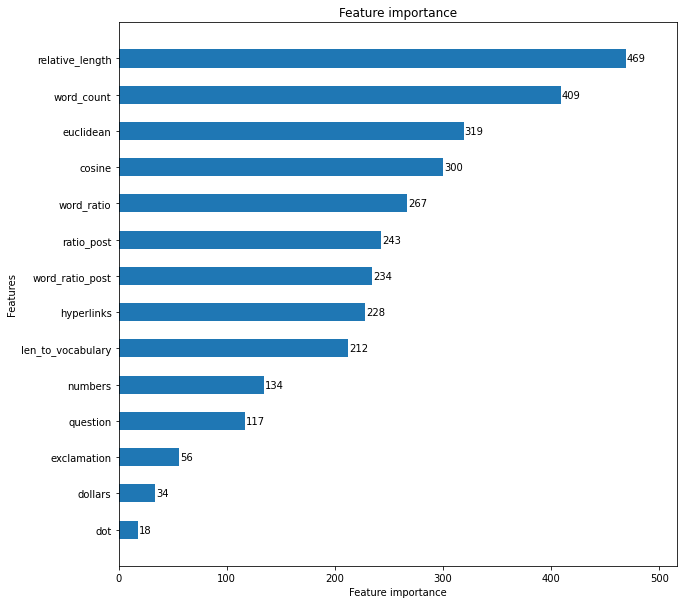

In [1578]:
#построим график для признаков, использованных для обучения модели lgbm_best
plot_importance(lgbm_best, height = 0.5, ignore_zero = False, figsize = (10,10), grid = False)

##### Описание признаков
Признаки на основе векторных представлений текстов постов и комментариев, полученных при помощи CountVectorizer. Для каждого поста и соответствущих пяти комментариев получен корпус, на основе которого составлены отдельные вектора для поска и каждого комментария.

Корпус: уникальные слова для группы из поста и пяти комментариев к нему

При этом рассчитаны признаки:
* relative_length - отношение количества слов в комментарии к суммарному количеству слов в комментариях 
* len_to_vocabulary - отношение количества слов к комментарии к размеру корпуса (то есть к количеству уникальных слов, используемых в комментариях)
* word_count - количество уникальных слов в отдельном комментарии (без повторов) То есть для поста "ура ура ура" значение будет равно 1
* word_ratio - отношение уникальных слов в отдельном комментарии к размеру корпуса
* ratio_post - отношение количества слов в комментарии к количеству слов в посте (добавлена единица, чтобы избежать деления на ноль для немногих постов в тесте)
* word_ratio_post - отношение количества уникальных слов в комментарии к количеству уникальных слов в посте
* numbers - количество чисел в комментарии
* hyperlinks - количество гиперссылок в комментарии
* dot - количество символов @ в комментарии
* question - количество вопросительных знаков в комментарии
* exclamation - количество восклицательных знаков в комментарии
* dollars - количество символов $ в комментарии
* cosine - косинусное сходство между комментарием и постом
* euclidean - эвклидово расстояние между комментарием и постом

#### LGBMRanker

Обучим модель LGBMRanker на подготовленной выборке с признаками, созданными на основе характеристик слов и векторов

Подготовим признаки, таргеты и группы:

Признаки: X_train_data и X_test_data, подготовленные ранее 

Группы:

In [1309]:
query_train_lb = [5]*int(len(X_lb_train)/5)

In [1310]:
query_valid_lb = [5]*int(len(X_lb_test)/5)

LGBMRanker рассматривает более высокий ранг как наилучшую характеристику, а меньший ранг - как худшую. Поэтому обратим порядок оценок (при порядка от 0 к 4 метрика незначительно уменьшается)

In [1311]:
y_lb_train = np.array((4,3,2,1,0)*int(len(X_lb_train)/5))

In [1312]:
y_lb_valid = np.array((4,3,2,1,0)*int(len(X_lb_test)/5))

Создадим и обучим модель:

In [1313]:
gbm = lgb.LGBMRanker(n_estimators  = 250, num_leaves = 30, learning_rate = 0.1)

In [1314]:
gbm.fit(X_lb_train, y_lb_train, group=query_train_lb,
        eval_set=[(X_lb_valid, y_lb_valid)], eval_group=[query_valid_lb],
        eval_at=[5, 10, 40], early_stopping_rounds=200, verbose = False)

C:\Users\antwo\.conda\envs\ds_copy\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\antwo\.conda\envs\ds_copy\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMRanker(n_estimators=250, num_leaves=30)

In [1315]:
preds_gbm = gbm.predict(X_lb_test, raw_score = True)

Выведем значение метрики NDCG, полученное при обучении:

In [1316]:
gbm.best_score_

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('ndcg@5', 0.8417070809406322),
                          ('ndcg@10', 0.8417070809406322),
                          ('ndcg@40', 0.8417070809406322)])})

In [1317]:
preds_gbm[50:55]

array([-0.07277306, -0.11839459, -0.09422707,  0.13443489, -0.0264254 ])

**Комментарий** Не разобрались, как преобразовать в значения меток

#### Catboost Ranker

In [1117]:
from catboost import CatBoostRanker, Pool, MetricVisualizer

 Используем ранее подготовленные признаки X_train_data и X_test_data

In [1168]:
#признаки
X_cb_train = X_train_data.values
#таргет
y_cb_train = train_data['score'].values
#идентификаторы
queries_train = train_ids

In [1169]:
X_cb_train.shape

(344420, 14)

In [1170]:
#признаки
X_cb_valid = X_test_data.values
#таргет
y_cb_valid = test_data['score'].values
#идентификаторы
queries_valid = val_ids

In [1171]:
X_cb_val.shape

(86105, 14)

Приведем оценки к диапазону от 0 до 1:

In [1179]:
y_cb_train = y_cb_train/4
y_cb_valid = y_cb_val/4

Пулы для обучения модели:

In [1181]:
tr_pool = Pool(
    data=X_cb_train,
    label=y_cb_train,
    group_id=queries_train
)

val_pool = Pool(
    data=X_cb_valid,
    label=y_cb_valid,
    group_id=queries_valid
)

In [1182]:
default_parameters = {
    'iterations': 2000,
    'custom_metric': ['NDCG', 'PFound', 'AverageGain:top=10'],
    'verbose': False,
    'random_seed': 0,
}

parameters = {}

In [1183]:
def fit_model(loss_function, additional_params=None, train_pool=tr_pool, test_pool=val_pool):
    parameters = deepcopy(default_parameters)
    parameters['loss_function'] = loss_function
    parameters['train_dir'] = loss_function
    
    if additional_params is not None:
        parameters.update(additional_params)
        
    model = CatBoostRanker(**parameters)
    model.fit(tr_pool, eval_set=val_pool, plot=True)
    
    return model

In [1184]:
model = fit_model('PairLogit', {'custom_metric': ['NDCG']})

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [1185]:
print(model.get_best_score())

{'learn': {'PairLogit': 0.5956154568179094}, 'validation': {'NDCG:type=Base': 0.886433971525708, 'PairLogit': 0.6036515992534413}}


In [1186]:
preds = model.predict(X_cb_val)

In [1187]:
preds[0:20]

array([ 0.04148832,  0.1491929 , -0.30291415, -0.55261498, -0.24219519,
        0.61186584,  0.79449197, -0.22202989,  0.57793946, -0.59758079,
        0.41830673,  0.45075937, -0.87036289, -0.09558715, -0.18790265,
       -0.85470317,  0.69454838,  0.19323311,  0.22360351,  0.53495115])

### Обучение по признакам TF IDF

#### Регрессия: LGBMRegressor, признаки TF IDF
Выполним обучение модели регрессии, используя значения от 0 до 4 в качестве целевого признака. Затем будем предсказывать значения, сортировать и назначать ранг в соответствии с порядком

In [1318]:
# создадим модель LGBMRegressor
lgbm = LGBMRegressor(random_state=38)

# создадим список гиперпараметров
lgbm_parameters = {
    'num_leaves': [15, 20],
    'n_estimators': [100, 300],
    'learning_rate': [0.1, 0.3],
    'max_depth': [9, 20]
}

# передадим модель и гиперпараметры для обучения с кросс-валидацией и для подбора гиперпаматеров
lgbm_tf_cv = GridSearchCV(lgbm,
                    param_grid=lgbm_parameters,
                    scoring='neg_mean_absolute_error',
                    cv=5)

In [1319]:
%%time
# выполним обучение модели с подбором гиперпараметров
lgbm_tf_cv.fit(tf_train, y_lbreg_train)

CPU times: total: 4h 4min 24s
Wall time: 2h 25min 3s


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=38),
             param_grid={'learning_rate': [0.1, 0.3], 'max_depth': [9, 20],
                         'n_estimators': [100, 300], 'num_leaves': [15, 20]},
             scoring='neg_mean_absolute_error')

Значение метрики MAE при кросс валидации

In [1322]:
lgbm_tf_cv.best_score_

-1.1361488766646013

In [1591]:
lgbm_tf_best = lgbm_tf_cv.best_estimator_

In [1592]:
lgbm_tf_param = lgbm_tf_cv.best_params_

In [1593]:
lgbm_tf_param

{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 300, 'num_leaves': 20}

Вычислим предсказания на тестовой выборке, используя подготовленную ранее функцию:

In [1448]:
lgb_pred_scores = regress_pred(lgbm_tf_cv, tf_test)

Вычислим значение NDCG для тестовой выборки

In [1453]:
ndcg_score(real_scr_test, lgb_pred_scores)

0.8759816881708969

#### Бинарная классификация с пересчетом вероятностей в ранги: логистическая регрессия

Проведем обучение модели, используя комментарии с рейтингом 0 и рейтингом 4 (данные подготовлены ранее). Затем будем использовать вероятности классов в предсказаниях для сортировки значений и вычисления ранга

In [1543]:
# записываем возможные значения гиперпараметров для логистической регрессии
parameters = {
    'C': [1, 9, 10]
}

Обучим модель на матрице TF IDF для обучающей выборки, используя кросс-валидацию

In [1544]:
# создадим модель логистической регрессии:
# , class_weight = 'balanced')
logreg = LogisticRegression(random_state=38, max_iter=1000)
# для инструмента GridSearhCV передадим модель, значения гиперпараметров, метод оценки
clf_logreg = GridSearchCV(logreg,               
                          param_grid=parameters,  
                          scoring='f1',        
                          cv=5)

In [1545]:
%%time
# обучаем модель логистической регрессии на полной обучающей выборке
clf_logreg.fit(tf_binary, y_binary)

CPU times: total: 1min 44s
Wall time: 1min 55s


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=38),
             param_grid={'C': [1, 9, 10]}, scoring='f1')

In [1546]:
print("Гиперпараметры :", clf_logreg.best_params_)
print("Значение F1:",clf_logreg.best_score_)

Гиперпараметры : {'C': 1}
Значение F1: 0.6782004709597153


In [1547]:
# сохраним модель с лучшим результатом
lr = clf_logreg.best_estimator_

Вычисление предсказаний для бинарной классификации, преобразование в ранги и вычисление метрики

Составим функцию, которая вычисляет вероятности для классов, сортирует их и преобразует
в array со значениями ранга от 0 до 4

In [1548]:
def convert_pred(model, sample):
    """
    Функция вычисляет вероятности предсказаний и переводит их в ранги
    Аргументы: 
    model: модель для вычисления предсказаний
    sample: выборка, на которой вычисляются предсказания
    
    """
    pr_proba = model.predict_proba(sample)
    probabilities = pr_proba[:,0]
    num = int(probabilities.shape[0]/5)
    reshaped_probs = np.reshape(probabilities, (num, 5))
    result = np.zeros((num, 5), dtype = int)
    for i in range(num):
        result[i] = np.argsort(reshaped_probs[i])
    return result

Применим функцию к тестовой выборке:

In [1549]:
pred_scores = convert_pred(lr, tf_test)

Сформируем матрицу с реальными значениями, используя данные об упорядоченности комментариев по рангу от 0 к 4: 

In [1550]:
real_scores_test = np.reshape(y_test, (int(tf_test.shape[0]/5), 5))

Вычислим значение метрики NDCG для тестовой выборки

In [1551]:
ndcg_score(real_scores_test, pred_scores)

0.8710075377916576

### Предсказание ранга комментария по его длине

По данным можно заметить, что чем длинне комментарий, тем лучше ранг. Поэтому ранг можно предсказывать только по длине. Вычислим длину комментариев в тестовой (валидационной) выборке.

In [1561]:
train_comm['length'] = train_comm['comment'].apply(lambda x: len(x))
test_comm['length'] = test_comm['comment'].apply(lambda x: len(x))

In [1562]:
test_comm['length'].max()

1200

Составим функцию, которая для каждых 5 комментариев сортирует длину комментариев и назначает ранги: 0 - самый длинный, 4 - самый короткий

In [1563]:
def length_pred(sample):
    """
    Функция сортирует записи по длине комментариев и назначает ранги
    Аргументы: 
    sample: выборка, на которой вычисляются предсказания
    
    """
    length = sample.values
    num = int(length.shape[0]/5)
    reshaped_length = np.reshape(length, (num, 5))
    result = np.zeros((num, 5), dtype = int)
    for i in range(num):
        result[i] = np.argsort(reshaped_length[i])#[::-1]
    return result

In [1564]:
pred_by_length = length_pred(test_comm['length'])

Вычислим значение метрики

In [1565]:
ndcg_score(real_scores_test, pred_by_length)

0.732297236162167

## Выводы по обучению моделей

Применены два подхода для получения признаков:
* вычисление производных признаков после преобразования тестов в векторы (относительные длины текстов и словарей, косинальное сходство и эвклидово расстояние) с использованием также дополнительных характеристик (гиперссылки, некоторые спецсимволы)
* расчет значений TF IDF на корпусе, включающем все тексты, с последующим расчетом значений для комментариев в обучающей и валидационной выборках.

Проведено обучение моделей регрессии и классификации. Полученные предсказания ранжировались по величине в случае регрессии и по вероятности положительного класса в случае классификации.

На выборках с вычисленными производными признаками обучены модели:
* LGBMRegressor, значение метрики NDCG на валидационной выборке 0.882
* LGBMRanker, значение метрики NDCG при обучении 0.84
* CatboostRanker, значение метрики NDCG при обучении 0.886

На выборках с признаками TF IDF обучены модели:
* LGBMRegressor, значение на валидационной выборке 0.876
* логистическая регрессия для бинарной классификации, с пересчетом вероятностей в ранги, значение на валидационной выборке 0.87

При анализе данных выявлена связь между длиной комментария и оценкой. Поэтому составлена "модель" предсказаний ранга путем ранжирования по длине в каждой пятерке. Получено значение метрики NDCG 0.73

Для вычисления предказаний на тестовой выборке в задании выбрана модель **LGBMRegressor**, обученная на выборке с вычисленными признаками

## Подготовка тестовой выборки и формирование предсказаний

### Загрузка  файла и предобработка данных

In [1398]:
df_test = pd.read_json('C:/Andrey/datasets/chg/ranking_test.jsonl', lines = True)

In [1399]:
df_test.head()

,text,comments
0,"iOS 8.0.1 released, broken on iPhone 6 models,...",[{'text': 'I&#x27;m still waiting for them to ...
1,Ask HN: How do US HNers get their health insur...,[{'text': 'Get it from your employer. It&#x27;...
2,San Diego Researcher Crowdfunding Patent-Free ...,[{'text': 'What I don&#x27;t understand is why...
3,Rethinking the origins of the universe,[{'text': 'I&#x27;m not a physicist. I imagin...
4,SlackTextViewController: A new growing text in...,[{'text': 'As someone that doesn&#x27;t do iOS...


In [1400]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14004 entries, 0 to 14003
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      14004 non-null  object
 1   comments  14004 non-null  object
dtypes: object(2)
memory usage: 218.9+ KB


In [1401]:
test_posts = df_test.copy()

In [1402]:
#меняем гиперссылки на http
test_posts['text'] = test_posts['text'].replace(r"http\S+", "http", regex=True)
#оставляем буквы, цифры, некоторые символы (чтобы учесть темы финансов, эл адреса, интонации)
test_posts['text'] = test_posts['text'].replace(r"[^a-zA-Z0-9$@'?+!]", " ", regex=True)
# убираем символы переноса строки
test_posts["text"] = test_posts["text"].replace(r"[\n]", " ", regex=True)
# переведем в нижний регистр
test_posts["text"] = test_posts["text"].str.lower()
test_posts["text"] = test_posts["text"].replace(r"\?", " ? ", regex=True)
test_posts["text"] = test_posts["text"].replace(r"\!", " ! ", regex=True)
test_posts["text"] = test_posts["text"].replace(r"\@", " @ ", regex=True)
test_posts["text"] = test_posts["text"].replace(r"\$", " $ ", regex=True)

Выведем в новом датафрейме комментарии и ранги в отдельных столбцах:

In [1403]:
dt = [{f'{k}{i}': v for i,y in enumerate(x, 1) for k,v in y.items()} for x in test_posts['comments']]
dft = pd.DataFrame(dt, index=test_posts.index).sort_index(axis=1)

In [1404]:
dft.head()

,score1,score2,score3,score4,score5,text1,text2,text3,text4,text5
0,None,None,None,None,None,I&#x27;m still waiting for them to stabilize w...,"For those who upgraded, no need to do a restor...",Upgraded shortly after it was released and suf...,I think they were under a lot of pressure on t...,Fix for those who already updated: http:&#x2F...
1,None,None,None,None,None,Get it from your employer. It&#x27;s better an...,As someone who moved from the UK to US under a...,"I went to http:&#x2F;&#x2F;healthcare.gov, fil...","Full time employed, health insurance through m...",Your options depend on where you live.I signed...
2,None,None,None,None,None,What I don&#x27;t understand is why drugs deve...,To everyone sure this will fail because of the...,People don&#x27;t seem to realize how expensiv...,"Many years ago, I worked in a lab where I synt...",I think the negative comments on here have got...
3,None,None,None,None,None,I&#x27;m not a physicist. I imagine that if I...,I&#x27;m not at all acquainted with astrophysi...,This paper claims that black holes can&#x27;t ...,Interesting; if the paper finds general accept...,Ethan Siegel just posted a detailed response t...
4,None,None,None,None,None,As someone that doesn&#x27;t do iOS developmen...,Apple developed Swift to make developer&#x27;s...,"So I&#x27;m making iOS apps sometimes, but hav...",&gt; Inverted mode for displaying cells upside...,cool. I was just shopping for a new growing t...


In [1405]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14004 entries, 0 to 14003
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   score1  0 non-null      object
 1   score2  0 non-null      object
 2   score3  0 non-null      object
 3   score4  0 non-null      object
 4   score5  0 non-null      object
 5   text1   14004 non-null  object
 6   text2   14004 non-null  object
 7   text3   14004 non-null  object
 8   text4   14004 non-null  object
 9   text5   14004 non-null  object
dtypes: object(10)
memory usage: 1.1+ MB


Подготовим текст в столбцах с комментами также, как и для постов:

In [1406]:
cols = ['text1', 'text2', 'text3', 'text4', 'text5']
for col in cols:
    dft[col] = dft[col].replace(r"http\S+", "http", regex=True)
    dft[col] = dft[col].replace(r"[^a-zA-Z0-9$@'?+!]", " ", regex=True)
    dft[col] = dft[col].replace(r"[\n]", " ", regex=True)
    dft[col] = dft[col].str.lower()
    dft[col] = dft[col].replace(r"\?", " ? ", regex=True)
    dft[col] = dft[col].replace(r"\!", " ! ", regex=True)
    dft[col] = dft[col].replace(r"\@", " @ ", regex=True)
    dft[col] = dft[col].replace(r"\$", " $ ", regex=True)

In [1407]:
dft.head()

,score1,score2,score3,score4,score5,text1,text2,text3,text4,text5
0,None,None,None,None,None,i x27 m still waiting for them to stabilize w...,for those who upgraded no need to do a restor...,upgraded shortly after it was released and suf...,i think they were under a lot of pressure on t...,fix for those who already updated http
1,None,None,None,None,None,get it from your employer it x27 s better an...,as someone who moved from the uk to us under a...,i went to http filled out some online forms an...,full time employed health insurance through m...,your options depend on where you live i signed...
2,None,None,None,None,None,what i don x27 t understand is why drugs deve...,to everyone sure this will fail because of the...,people don x27 t seem to realize how expensiv...,many years ago i worked in a lab where i synt...,i think the negative comments on here have got...
3,None,None,None,None,None,i x27 m not a physicist i imagine that if i...,i x27 m not at all acquainted with astrophysi...,this paper claims that black holes can x27 t ...,interesting if the paper finds general accept...,ethan siegel just posted a detailed response t...
4,None,None,None,None,None,as someone that doesn x27 t do ios developmen...,apple developed swift to make developer x27 s...,so i x27 m making ios apps sometimes but hav...,gt inverted mode for displaying cells upside...,cool i was just shopping for a new growing t...


### Исключение стоп слов из тестовой выборки

In [1408]:
test_posts['text'] = test_posts['text'].apply(lambda text: remove_stopwords(text))

In [1409]:
cols = ['text1', 'text2', 'text3', 'text4', 'text5']
for col in cols:
    dft[col] = dft[col].apply(lambda text: remove_stopwords(text))

### Лемматизация в тестовой выборке

#### Лемматизация постов

In [ ]:
# применяем лемматизацию к словам в предложениях из столбца датафрейма, исключая пробелы
tqdm.pandas()
test_posts['lemm'] = test_posts['text'].progress_apply(lambda text: " ".join(token.lemma_ for token in nlp(text)
                                                                if not token.is_space))

In [24]:
test_posts['lemm'] = test_posts['lemm'].apply(lambda text: remove_stopwords(text))

In [25]:
# исключаем апострофы (могли остаться, если были в словах, которые не подходят под схемы для лемматизации)
test_posts["lemm"] = test_posts["lemm"].replace(r"[']", " ", regex=True)

In [26]:
# удаляем столбец с исходным текстом
test_posts = test_posts.drop(columns=['text'], axis=1)

In [27]:
# удаляем столбец с комментариями
test_posts = test_posts.drop(columns=['comments'], axis=1)

In [28]:
test_posts = test_posts.rename(columns = {'lemm': 'text'})

In [29]:
test_posts.head()

,length,text
0,133,summer y combinator fundee decide continue sta...
1,32,cbs acquires fm $ 280 m
2,35,costco anti wal mart
3,58,fortune favor big turd screw money art
4,59,startupweekend 70 founder create company weekend


In [30]:
# сохраняем полученный файл
filepath = Path('C:/Andrey/datasets/chg/test_posts_lemmatized.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
test_posts.to_csv(filepath, index=False)

Загрузка сохраненного файла после лемматизации

In [1410]:
df_test_posts = pd.read_csv('C:/Andrey/datasets/chg/test_posts_lemmatized.csv')

In [1411]:
df_test_posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14004 entries, 0 to 14003
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    13999 non-null  object
dtypes: object(1)
memory usage: 109.5+ KB


In [1412]:
df_test_posts = df_test_posts.fillna(' ')

#### Лемматизация комментов (в отдельных ячейках, так как требуется много времени на каждый столбец)

In [34]:
# применяем лемматизацию к словам в предложениях из столбца датафрейма, исключая пробелы
tqdm.pandas()
dft['lemm1'] = dft['text1'].progress_apply(lambda text: " ".join(token.lemma_ for token in nlp(text)
                                                                if not token.is_space))

100%|██████████| 87525/87525 [23:57<00:00, 60.90it/s] 


In [35]:
# применяем лемматизацию к словам в предложениях из столбца датафрейма, исключая пробелы
tqdm.pandas()
dft['lemm2'] = dft['text2'].progress_apply(lambda text: " ".join(token.lemma_ for token in nlp(text)
                                                                if not token.is_space))

100%|██████████| 87525/87525 [18:55<00:00, 77.10it/s] 


In [36]:
# применяем лемматизацию к словам в предложениях из столбца датафрейма, исключая пробелы
tqdm.pandas()
dft['lemm3'] = dft['text3'].progress_apply(lambda text: " ".join(token.lemma_ for token in nlp(text)
                                                                if not token.is_space))

100%|██████████| 87525/87525 [19:15<00:00, 75.73it/s] 


In [37]:
# применяем лемматизацию к словам в предложениях из столбца датафрейма, исключая пробелы
tqdm.pandas()
dft['lemm4'] = dft['text4'].progress_apply(lambda text: " ".join(token.lemma_ for token in nlp(text)
                                                                if not token.is_space))

100%|██████████| 87525/87525 [21:19<00:00, 68.41it/s]  


In [38]:
# применяем лемматизацию к словам в предложениях из столбца датафрейма, исключая пробелы
tqdm.pandas()
dft['lemm5'] = dft['text5'].progress_apply(lambda text: " ".join(token.lemma_ for token in nlp(text)
                                                                if not token.is_space))

100%|██████████| 87525/87525 [17:30<00:00, 83.35it/s] 


In [40]:
lmt = [['lemm1', 'lemm2', 'lemm3','lemm4','lemm5']]

for col in lmt:
    dft[col] = dft[col].replace(r"[']", "", regex=True)

In [41]:
# удаляем столбец с исходным текстом
dft = dft.drop(columns=['text1', 'text2','text3','text4','text5'], axis=1)

In [42]:
# сохраняем полученный файл
filepath = Path('C:/Andrey/datasets/chg/test_comm_lemmatized.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
dft.to_csv(filepath, index=False)

In [1413]:
df_test_comm = pd.read_csv('C:/Andrey/datasets/chg/test_comm_lemmatized.csv')

In [1414]:
df_test_comm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14004 entries, 0 to 14003
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   score1  0 non-null      float64
 1   score2  0 non-null      float64
 2   score3  0 non-null      float64
 3   score4  0 non-null      float64
 4   score5  0 non-null      float64
 5   lemm1   14003 non-null  object 
 6   lemm2   14002 non-null  object 
 7   lemm3   14003 non-null  object 
 8   lemm4   14004 non-null  object 
 9   lemm5   14001 non-null  object 
dtypes: float64(5), object(5)
memory usage: 1.1+ MB


In [1415]:
df_test_comm = df_test_comm.fillna(' ')

### Объединение постов и комментариев в один датафрейм

Объединим посты и комментарии в один датафрейм:

In [1416]:
clean_test = df_test_posts.join(df_test_comm)

In [1417]:
clean_test.head()

,text,score1,score2,score3,score4,score5,lemm1,lemm2,lemm3,lemm4,lemm5
0,ios 8 0 1 release break iphone 6 model withdraw,,,,,,x27 m wait stabilize wifi ipad sith ios 8 qual...,upgrade need restore option click quot update ...,upgrade shortly release suffer consequence abl...,think lot pressure healthkit big flagship io 8...,fix update http
1,ask hn hner health insurance ?,,,,,,employer x27 s well cheap market allow supplem...,move uk identical condition let job offer heal...,go http fill online form pick plan x27 s like ...,time employ health insurance employer group co...,option depend live sign cover california subsi...
2,san diego researcher crowdfunde patent free ca...,,,,,,x27 t understand drug develop public money gov...,sure fail money require ask tell mom neighbor ...,people x27 t realize expensive bring new pharm...,year ago work lab synthesize variant interfero...,think negative comment get upside research tre...
3,rethink origin universe,,,,,,x27 m physicist imagine exciting news exciting...,x27 m acquaint astrophysic remember see articl...,paper claim black hole x27 t come existence su...,interesting paper find general acceptance x27 ...,ethan siegel post detailed response http
4,slacktextviewcontroller new grow text input io,,,,,,x27 t ios development boggle mind guy build fe...,apple develop swift developer x27 s expressive...,x27 m make ios app implement chat feature want...,gt invert mode display cell upside catransform...,cool shop new grow text view hpgrowingtextview...


In [1418]:
clean_test = clean_test.fillna(' ')

Вычисляем длину комментариев в символах:

In [1597]:
clean_test['length'] = clean_test['text'].apply(lambda x: len(x))
clean_test['len1'] = clean_test['lemm1'].apply(lambda x: len(x))
clean_test['len2'] = clean_test['lemm2'].apply(lambda x: len(x))
clean_test['len3'] = clean_test['lemm3'].apply(lambda x: len(x))
clean_test['len4'] = clean_test['lemm4'].apply(lambda x: len(x))
clean_test['len5'] = clean_test['lemm5'].apply(lambda x: len(x))

(0.0, 1500.0)

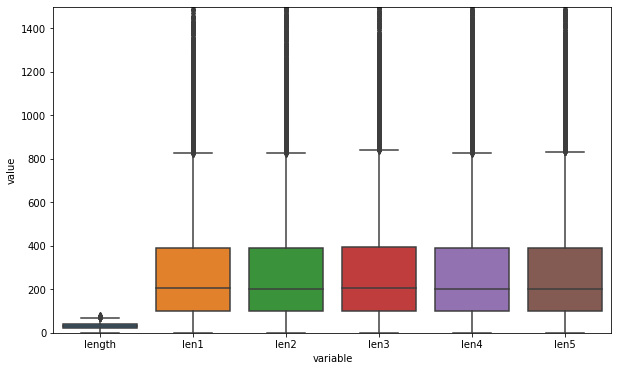

In [1599]:
len_test_data = clean_test[['length', 'len1', 'len2', 'len3', 'len4','len5']]
ax = plt.figure(figsize=(10,6))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(len_test_data))
ax.set_ylim(0,1500)

Комментарии распределены между группами равным образом

Разворачиваем комментарии в один столбец:

In [1419]:
test_fin = get_df(clean_test)

In [1420]:
test_fin.shape

(70020, 1)

### Подготовка признаков в тестовой выборке

#### Преобразование TF IDF для тестовой выборки

In [1566]:
test_fin_corpus = test_fin['comment'].values

In [1567]:
# применяем расчет TF IDF к комментариям для тестовой выборки
tf_fin_test = count_tf_idf.transform(test_fin_corpus)
tf_fin_test.shape

(70020, 12801)

#### Признаки по характеристикам векторов

In [1426]:
test_fin_features = get_features(clean_test)

C:\Users\antwo\.conda\envs\ds_copy\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'can', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [1471]:
# датафрейм для признаков из тестовой выборки
X_test_fin = pd.DataFrame.from_dict(test_fin_features)
X_test_fin.shape

(70020, 14)

In [1440]:
X_test_fin.head()

,relative_length,len_to_vocabulary,word_count,word_ratio,ratio_post,word_ratio_post,numbers,hyperlinks,dot,question,exclamation,dollars,cosine,euclidean
0,0.181818,0.20,12,0.200000,1.714286,1.714286,4,0,0,0,0,0,0.117851,4.000000
1,0.181818,0.20,11,0.183333,1.714286,1.571429,3,1,0,0,0,0,0.000000,4.472136
2,0.272727,0.30,18,0.300000,2.571429,2.571429,2,0,0,0,0,0,0.096225,4.690416
3,0.318182,0.35,19,0.316667,3.000000,2.714286,3,0,0,0,0,0,0.163299,5.196152
4,0.045455,0.05,3,0.050000,0.428571,0.428571,0,1,0,0,0,0,0.000000,3.000000


### Вычисление предсказаний:

In [1458]:
test_scores = regress_pred(lgbm_cv, X_test_fin)

In [1459]:
test_scores.shape

(14004, 5)

In [1461]:
scores = pd.DataFrame(data=test_scores)

In [1462]:
scores

,0,1,2,3,4
0,3,2,1,0,4
1,1,2,4,3,0
2,4,1,3,2,0
3,1,0,3,2,4
4,4,1,2,3,0
...,...,...,...,...,...
13999,3,1,0,4,2
14000,0,3,1,4,2
14001,3,1,2,4,0
14002,0,3,2,4,1


In [1472]:
# сохраняем полученный файл
filepath = Path('C:/Andrey/datasets/chg/scores.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
scores.to_csv(filepath, index=False)

In [1587]:
scrs = pd.read_json('C:/Andrey/datasets/chg/scores.json', orient='index')

In [1588]:
scrs

,0,1,2,3,4
0,3,2,1,0,4
1,1,2,4,3,0
2,4,1,3,2,0
3,1,0,3,2,4
4,4,1,2,3,0
...,...,...,...,...,...
13999,3,1,0,4,2
14000,0,3,1,4,2
14001,3,1,2,4,0
14002,0,3,2,4,1
